## Rossman store sales (Kaggle competition)

The goal is to make a forecast for upcoming sales in 1115 Rossmann stores based on data from from 2013-01-01 to 2015-07-31. The forecast period is 2015-08-01 to 2015-09-17. 

In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, '43285b0e-9e6e-4aad-8a96-3c40cf6f8874', 'p-feff31088fbf9bf46cb5e9470d87ed7c2432902c')
pc = project.project_context


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200508182041-0000
KERNEL_ID = a5c8732e-d82a-445b-b4aa-45504f5552e0


### Load data

Load the data containing the sales data, the data containing store information, a sample submission and the test data.

In [2]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-c661b205-b3f6-43f5-ba36-e66d9f64531f',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': '-ynWC7Y9F5nKlpdFO21VLMfHYNAPb03HUbUqKxnp07WH'
}

configuration_name = 'os_c63666ea1c9d403e811d4c86742ad623_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_train = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('train.csv', 'm5forecastingaccuracy-donotdelete-pr-5fybfotj7xtmkk'), inferSchema= 'true')
#df_train.take(1)


In [3]:

df_store = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('store.csv', 'm5forecastingaccuracy-donotdelete-pr-5fybfotj7xtmkk'), inferSchema= 'true')
#df_store.take(1)


In [4]:
# Load a sample submission showing the format of the data that should be submitted to Kaggle
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c63666ea1c9d403e811d4c86742ad623 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='-ynWC7Y9F5nKlpdFO21VLMfHYNAPb03HUbUqKxnp07WH',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_c63666ea1c9d403e811d4c86742ad623.get_object(Bucket='m5forecastingaccuracy-donotdelete-pr-5fybfotj7xtmkk',Key='sample_submission.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

sample_sub = pd.read_csv(body)
#sample_sub.head(1)


In [5]:
# load data used for test predictions to Kaggle
df_test = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('test.csv', 'm5forecastingaccuracy-donotdelete-pr-5fybfotj7xtmkk'), inferSchema= 'true')
df_test.take(1)


[Row(Id=1, Store=1, DayOfWeek=4, Date=datetime.datetime(2015, 9, 17, 0, 0), Open=1, Promo=1, StateHoliday='0', SchoolHoliday=0)]

In [7]:
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import numpy as np
from heatmap import corrplot
import matplotlib.pyplot as plt

#### Check the schema of the dataframe containing the store data

In [8]:
df_store.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: integer (nullable = true)
 |-- CompetitionOpenSinceYear: integer (nullable = true)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)



In [9]:
#Join the data from df_store with the sales data in df_data_1

df_j = df_train.join(df_store, "Store")
df_j_test = df_test.join(df_store, "Store")

print('Number of records in df_j:', df_j.count())
print('Number of records in df_j_test:', df_j_test.count())

Number of records in df_j: 1017209
Number of records in df_j_test: 41088


Remove the entries when the store is closed. Only stores which are open during the forecast period needs to be predicted. So the model doesn't have to deal with closed stores.

In [10]:
# Remove entries when store is closed (Open = 0) from training data.

df_j = df_j.filter(df_j.Open == 1)



In [11]:
print('Number of records in df_j:', df_j.count())


Number of records in df_j: 844392


In [12]:
df_j.select(F.countDistinct("Store")).show()

+---------------------+
|count(DISTINCT Store)|
+---------------------+
|                 1115|
+---------------------+



In [13]:
df_j_pandas = df_j.toPandas()

#### Correlation plot
Plot the correlations to see which features have a strong correlation. Of course Customers have a strong correlation to Sales, but the customers feature will not be available in the test set.

Also Promo seems to correlate with the Sales (meaning that the store is running a promotion on a specific day).

Features that actually are categorical (such as DayOfWeek, Year, Month, Week) is ignored (will be onehot-encoded later).

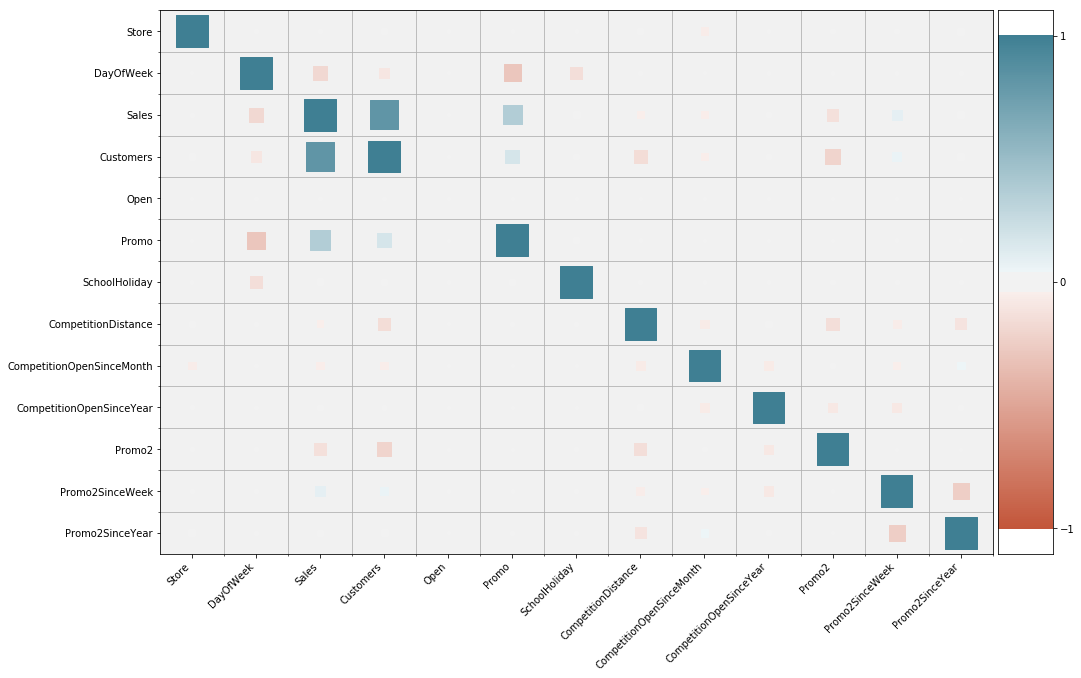

In [14]:

fig = plt.gcf()
fig.set_size_inches( 16, 10)
corrplot(df_j_pandas.corr(), size_scale=1000)

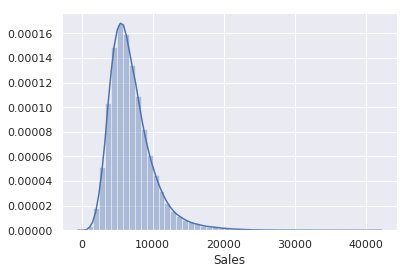

In [15]:
sns.set(color_codes=True)
sns.distplot(df_j_pandas.Sales);

In [17]:
max_sales = df_j.agg({'Sales': 'max'}).collect()[0][0]
print('Max Sales:', max_sales)

Max Sales: 41551


In [18]:
print('Open store days where Sales = 0:', df_j.filter(df_j.Sales == 0).count())

Open store days where Sales = 0: 54


In [19]:
df_j.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: integer (nullable = true)
 |-- CompetitionOpenSinceYear: integer (nullable = true)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)



In [20]:
df_j_test.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Id: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: integer (nullable = true)
 |-- CompetitionOpenSinceYear: integer (nullable = true)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)



### Create features

Create a feature for days since competition opene

In [21]:
#Calculate days since competition opened

import pyspark.sql.functions as F

cols_to_drop = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'CompOpenSince']

df_j = df_j.withColumn("CompOpenSince", F.to_date(F.concat_ws("-", "CompetitionOpenSinceYear", "CompetitionOpenSinceMonth")))
df_j_test = df_j_test.withColumn("CompOpenSince", F.to_date(F.concat_ws("-", "CompetitionOpenSinceYear", "CompetitionOpenSinceMonth")))

df_j = df_j.withColumn('DaysSinceCompOpen', F.datediff(df_j.Date, df_j.CompOpenSince))
df_j_test = df_j_test.withColumn('DaysSinceCompOpen', F.datediff(df_j_test.Date, df_j_test.CompOpenSince))

df_j = df_j.drop(*cols_to_drop)
df_j_test = df_j_test.drop(*cols_to_drop)

df_j.take(1)


[Row(Store=1, DayOfWeek=5, Date=datetime.datetime(2015, 7, 31, 0, 0), Sales=5263, Customers=555, Open=1, Promo=1, StateHoliday='0', SchoolHoliday=1, StoreType='c', Assortment='a', CompetitionDistance=1270, Promo2=0, Promo2SinceWeek=None, Promo2SinceYear=None, PromoInterval=None, DaysSinceCompOpen=2524)]

Extract features from the date

In [22]:
# Extract year, month and week from date

df_j = df_j.withColumn('Year',F.year('Date'))
df_j = df_j.withColumn('Month',F.month('Date'))
df_j = df_j.withColumn('Week',F.weekofyear('Date'))

df_j_test = df_j_test.withColumn('Year',F.year('Date'))
df_j_test = df_j_test.withColumn('Month',F.month('Date'))
df_j_test = df_j_test.withColumn('Week',F.weekofyear('Date'))



In [23]:
df_j.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)
 |-- DaysSinceCompOpen: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)



In [24]:
# Change datatype of some columns with wrong dtype

cols_to_double = ['DaysSinceCompOpen', 'CompetitionDistance', 'Month', 'DayOfWeek', 'Week']

for col in cols_to_double:
    df_j = df_j.withColumn(col, df_j[col].cast('double'))
    df_j_test = df_j_test.withColumn(col, df_j_test[col].cast('double'))

df_j = df_j.withColumn('Sales', df_j['Sales'].cast('double'))



In [25]:
def count_missings(spark_df,sort=True):
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        df = df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)
        return df[(df['count'] > 0)]

    return df
count_missings(df_j, sort=True)


,count
Promo2SinceWeek,423307
Promo2SinceYear,423307
DaysSinceCompOpen,268619
CompetitionDistance,2186


In [26]:
# Extract the maximum distance to a competitor store

max_comp_distance = df_j.agg({'CompetitionDistance': 'max'}).collect()[0][0]
print('Max CompetitionDistance:', max_comp_distance)


Max CompetitionDistance: 75860.0


In [27]:
# Fill in missing values

# For DaysSinceCompOpen fill in 0 as the missing value
df_j = df_j.fillna(0, subset='DaysSinceCompOpen')
df_j_test = df_j_test.fillna(0, subset='DaysSinceCompOpen')

# For CompetitionDistance assume there is no competition store closer than the maximum competition distance + 1
df_j = df_j.fillna(max_comp_distance+1, subset='CompetitionDistance')
df_j_test = df_j_test.fillna(max_comp_distance+1, subset='CompetitionDistance')

# Fill in nulls with 0
cols_for_pred = ['PromoInterval', 'Assortment', 'StoreType', 'StateHoliday', 'Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'DaysSinceCompOpen']

df_test = df_test.fillna(0, subset=cols_for_pred)
df_j_test = df_j_test.fillna(0, subset=cols_for_pred)



In [28]:
df_j.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: double (nullable = false)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)
 |-- DaysSinceCompOpen: double (nullable = false)
 |-- Year: integer (nullable = true)
 |-- Month: double (nullable = true)
 |-- Week: double (nullable = true)



Create feature for average customers for each store, week and day of week. The customers data is not available for the testset but the average over the trainperiod can be added to test.

In [29]:
avg_cust_df = df_j.groupby('Store', 'Week', 'DayOfWeek').agg({'Customers' : 'avg'})     #avg('Customers')

In [30]:
avg_cust_df.show()

+-----+----+---------+------------------+
|Store|Week|DayOfWeek|    avg(Customers)|
+-----+----+---------+------------------+
|  649|17.0|      2.0| 395.6666666666667|
|  867|17.0|      2.0| 390.6666666666667|
| 1060|17.0|      2.0| 811.6666666666666|
|  647|17.0|      1.0|             747.0|
|  679|17.0|      1.0|            1211.0|
|  683|17.0|      1.0|             962.0|
|  839|17.0|      1.0|             712.0|
|  940|17.0|      1.0|             742.5|
|  966|17.0|      1.0|             695.0|
| 1060|17.0|      1.0|             890.5|
|  147|16.0|      6.0|1011.3333333333334|
|  179|16.0|      6.0|             969.0|
|  506|16.0|      6.0|             656.0|
|  498|16.0|      5.0|             772.5|
|  829|16.0|      5.0|             701.5|
|  968|16.0|      5.0|             896.0|
|  984|16.0|      5.0|             657.0|
|  107|16.0|      4.0|            1002.0|
|  117|16.0|      4.0| 569.6666666666666|
|  662|16.0|      4.0|             816.0|
+-----+----+---------+------------

In [31]:
df_j = df_j.join(avg_cust_df, ['Store', 'Week', 'DayOfWeek'])
df_j = df_j.withColumnRenamed('avg(Customers)', 'AvgCustomers')

df_j_test = df_j_test.join(avg_cust_df, on = ['Store', 'Week', 'DayOfWeek'], how='left')
df_j_test = df_j_test.withColumnRenamed('avg(Customers)', 'AvgCustomers')



In [32]:
# Fill in 0 when in avgCustomers when null
df_j_test = df_j_test.fillna(0, subset='AvgCustomers')

#### Time features
Features such as month, week and weekday are transformed into cyclical features with cos and sin transformations. This means that for example 'Month' which currently is a 1-dimensional feature ranging from 1-12 is converted into a 2-dimensional feature, one part with a sin transform and the other part with a cos transform. This makes the feature cyclical (meaning that after 12 comes 1). The same is done with weekday and week. Year is not transformed since it's not cyclical.

In [33]:
# Transform time features into cyclical features 
from pyspark.sql.functions import cos, sin

# Month features
df_j = df_j.withColumn('month_sin', sin((df_j.Month-1)*(2.*np.pi/12)))
df_j = df_j.withColumn('month_cos', cos((df_j.Month-1)*(2.*np.pi/12)))

df_j_test = df_j_test.withColumn('month_sin', sin((df_j_test.Month-1)*(2.*np.pi/12)))
df_j_test = df_j_test.withColumn('month_cos', cos((df_j_test.Month-1)*(2.*np.pi/12)))

# Week features
df_j = df_j.withColumn('week_sin', sin((df_j.Week-1)*(2.*np.pi/52)))
df_j = df_j.withColumn('week_cos', cos((df_j.Week-1)*(2.*np.pi/52)))

df_j_test = df_j_test.withColumn('week_sin', sin((df_j_test.Week-1)*(2.*np.pi/52)))
df_j_test = df_j_test.withColumn('week_cos', cos((df_j_test.Week-1)*(2.*np.pi/52)))

# Day of week features
df_j = df_j.withColumn('weekday_sin', sin((df_j.DayOfWeek-1)*(2.*np.pi/7)))
df_j = df_j.withColumn('weekday_cos', cos((df_j.DayOfWeek-1)*(2.*np.pi/7)))

df_j_test = df_j_test.withColumn('weekday_sin', sin((df_j_test.DayOfWeek-1)*(2.*np.pi/7)))
df_j_test = df_j_test.withColumn('weekday_cos', cos((df_j_test.DayOfWeek-1)*(2.*np.pi/7)))






In [34]:
df_j.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Week: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: double (nullable = false)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)
 |-- DaysSinceCompOpen: double (nullable = false)
 |-- Year: integer (nullable = true)
 |-- Month: double (nullable = true)
 |-- AvgCustomers: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)
 |-- week_sin: double (nullable 

In [36]:
# take a small sample of df_j to build up a model
df_js = df_j.sample(False, 0.00005, 42)

In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

cat_cols = ['PromoInterval', 'Assortment', 'StoreType', 'StateHoliday']
num_cols = ['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'DaysSinceCompOpen', 'Year', 'AvgCustomers',
           'month_sin', 'month_cos', 'week_sin', 'week_cos', 'weekday_sin', 'weekday_cos', 'Open']

cols_for_model = num_cols + cat_cols + ['Sales']

df_j_red = df_j[cols_for_model]

stages = []

# Convert categorical strings to index values
for cat_col in cat_cols:
    indexer = StringIndexer(inputCol=cat_col, outputCol= cat_col +'_idx', handleInvalid='keep')
    onehot = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol()], outputCols= [cat_col + '_dummy'])
    stages += [indexer, onehot]

ohecols = [col + '_dummy' for col in cat_cols]
    
# Assemble predictors into a single column 
assembler = VectorAssembler(inputCols=num_cols + ohecols, outputCol='features')

stages += [assembler]

s_train, s_test = df_j_red.randomSplit([0.8, 0.2], seed=1)

# Print out columns to be used in prediction
print(s_train.columns)

['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'DaysSinceCompOpen', 'Year', 'AvgCustomers', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'weekday_sin', 'weekday_cos', 'Open', 'PromoInterval', 'Assortment', 'StoreType', 'StateHoliday', 'Sales']


In [36]:
# Create a Gradient boosted tree regressor
gbt = GBTRegressor(featuresCol='features',
                           labelCol='Sales',
                           seed=1,
                           stepSize = 0.05,
                           maxIter = 100,
                           maxDepth = 4
                           )


stages += [gbt]


# Create a pipeline
pipeline = Pipeline(stages=stages)

# Create the evaluator, evaluate on Root mean square error
pip_evaluator = RegressionEvaluator(
    labelCol='Sales', predictionCol='prediction', metricName='rmse')





In [28]:
def gbt_with_cross_validation():
    # Create a parameter grid to try different parameters
    paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [4, 5, 6])
                 .build())



    # Use cross validation to find the best model
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=pip_evaluator, numFolds=5, seed=1)

    cvModel = cv.fit(s_train)

    # Get the best model from cross validation
    best_model = cvModel.bestModel

    # Look at the stages in the best model
    print(best_model.stages)

    # select last stage (the GBTRegressor) of the best model and see info regarding which depth the model has chosen, this can be used on any parameter
    print(best_model.stages[-1].explainParam('maxDepth'))

    # Generate predictions on testing data using the best model then calculate RMSE
    predictions = best_model.transform(s_test)
    rmse = pip_evaluator.evaluate(predictions)

    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    
    return cvModel.bestModel

model = gbt_with_cross_validation()

[StringIndexer_a7324f6e293b, OneHotEncoderEstimator_d27478aff88f, StringIndexer_4da27289da9a, OneHotEncoderEstimator_dd2d4d600659, StringIndexer_4bb8121ed221, OneHotEncoderEstimator_29f067d30cf3, StringIndexer_9beddf6a1ca9, OneHotEncoderEstimator_7a272c173783, VectorAssembler_bde647bbcc1d, GBTRegressionModel (uid=GBTRegressor_b2bdfa6d1497) with 100 trees]
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 4)
Root Mean Squared Error (RMSE) on test data = 3017.22


In [37]:
def gbt_model():
    g_model = pipeline.fit(s_train)
    
    predictions = g_model.transform(s_test)
    rmse = pip_evaluator.evaluate(predictions)

    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    
    return g_model



In [38]:
model = gbt_model()

Root Mean Squared Error (RMSE) on test data = 1266.09


In [39]:
# Choose the columns
df_j_test_red = df_j_test[num_cols + cat_cols]
#df_test = df_test.fillna(0, subset=columns_num)

# Make prediction
kaggle_pred = model.transform(df_j_test_red)



In [40]:
kaggle_pred.describe('prediction').show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|             41088|
|   mean| 6092.322485029553|
| stddev|2719.2386591009813|
|    min|1340.4128404751075|
|    max| 26544.91472764317|
+-------+------------------+



In [41]:
# Check the predictions for when the store is closed

kaggle_pred.filter(kaggle_pred['Open'] == 0).describe('prediction').show()

# Change predictions to 0 when store is closed
from pyspark.sql.functions import when   

kaggle_pred = kaggle_pred.withColumn('prediction', when(kaggle_pred['Open'] == 0, 0).otherwise(kaggle_pred['prediction']))

kaggle_pred.describe('prediction').show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|              5995|
|   mean| 2623.736145678136|
| stddev|  717.946796369639|
|    min|1340.4128404751075|
|    max|12305.728901005758|
+-------+------------------+

+-------+-----------------+
|summary|       prediction|
+-------+-----------------+
|  count|            41088|
|   mean|5709.502727598176|
| stddev|3291.307015204771|
|    min|              0.0|
|    max|26544.91472764317|
+-------+-----------------+



In [42]:
kp_pandas = kaggle_pred.select('prediction').toPandas()
ki_pandas = df_j_test.select('Id').toPandas()
kp_pandas['Id'] = ki_pandas['Id']
kp_pandas['Sales'] = kp_pandas['prediction']
kp_pandas = kp_pandas.drop(columns=['prediction'])

In [43]:
kp_pandas.head()


,Id,Sales
0,10274,4029.662094
1,8562,7085.925340
2,32543,4455.075825
3,18853,5905.947793
4,40255,6777.682910


In [44]:
project.save_data("submission4.csv", kp_pandas.to_csv(index=False))


{'file_name': 'submission4.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'm5forecastingaccuracy-donotdelete-pr-5fybfotj7xtmkk',
 'asset_id': 'c6cda1c5-71d5-43ab-bdff-cbff91a31009'}